<a href="https://colab.research.google.com/github/Garvit-Kr/Deep_L/blob/main/12.on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# WHEN TO USE GPU  ??
# --large complex model
# --simple but running many exp.

# WHY TO USE GPU  ??
# --most of DL is tons of simple but tedious matrix multiplication
# --training large model becomes time consuming
# --so, calculating is done on GPU


IMPLEMENTATION

In [ ]:
# import libraries

import time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
## Note: To run models on a GPU you must select from the menu:
#   -> Runtime
#     -> Change runtime type
#       -> Hardware accelerator
#         -> GPU

In [ ]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
#Build Model
net = nn.Sequential(
    nn.Linear(20,100),
    nn.ReLU(),
    nn.Linear(100,500),
    nn.ReLU(),
    nn.Linear(500,30),
    nn.ReLU(),
    nn.Linear(30,2)
      )

In [ ]:
# just some random fluff
data   = torch.randn((1000,20)) # samples X features
labels = torch.randint(low=0,high=2,size=(1,1000))

In [ ]:
# model
net.to(device)

# data
data   = data.to(device)
labels = labels.to(device)

In [ ]:
data

tensor([[ 1.2352, -0.0618, -0.9331,  ..., -0.7373, -0.4816, -0.9296],
        [-0.6352,  0.8086,  0.7817,  ...,  0.3487,  0.9703, -0.6727],
        [ 0.3043, -0.8304, -0.6547,  ...,  1.6597,  0.2271, -0.0299],
        ...,
        [-1.2769, -1.1184,  0.6548,  ..., -0.7802,  1.0080,  0.1541],
        [ 1.3959,  1.3650, -0.2652,  ...,  0.0713,  1.3035,  0.2090],
        [-0.7853, -1.1059, -1.0268,  ...,  0.4527,  0.9831,  0.8583]],
       device='cuda:0')

In [ ]:
# you can also create data directly on the GPU
dataG = torch.randn((1000,20),device=device)
dataC = torch.randn((1000,20),device='cpu')

print(data.device)
print(dataG.device)
print(dataC.device)

cuda:0
cuda:0
cpu


In [ ]:
output = net(data)

In [ ]:
output.device

device(type='cuda', index=0)

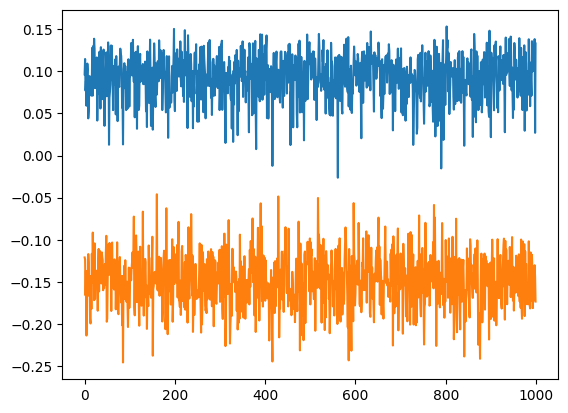

In [ ]:
# try to plot the data
#plt.plot(output.detach());

plt.plot(output.detach().cpu());

In [ ]:
# start the clock
starttime = time.process_time()

# move, run, retrieve
device = 'cuda:0'
net.to(device)
data   = data.to(device)
labels = labels.to(device)
output = net(data).detach().cpu()

# stop the clock
GPUtime = 1000*(time.process_time() - starttime)

In [ ]:
# start the clock
starttime = time.process_time()

# move, run, retrieve
device = 'cpu'
net.to(device)
data   = data.to(device)
labels = labels.to(device)
output = net(data).detach().cpu()

# stop the clock
CPUtime = 1000*(time.process_time() - starttime)

In [ ]:
# time in ms
[CPUtime,GPUtime]

[9.286552000000725, 2.7900309999999706]

In [ ]:
# but maybe "sending" it to the CPU takes too much overhead?

In [ ]:
# recreate network and data
net  = nn.Sequential(nn.Linear(20,100),nn.ReLU(),nn.Linear(100,500),nn.ReLU(),nn.Linear(500,30),nn.ReLU(),nn.Linear(30,2))
data = torch.randn((1000,20))

# rerun the experiment
starttime = time.process_time()
output    = net(data).detach()
CPUtime2  = 1000*(time.process_time() - starttime)

# report the results
[CPUtime2,CPUtime,GPUtime]

[3.5037720000001826, 9.286552000000725, 2.7900309999999706]

code NEW!

In [ ]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet(nUnits,nLayers):

  class mnistNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784,nUnits)

      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,10)



    # forward pass
    def forward(self,x):
      # input layer
      x = self.layers['input'](x)

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      # return output layer
      x = self.layers['output'](x)
      return F.log_softmax(x,dim=1)

  # create the model instance
  net = mnistNet(nUnits,nLayers)

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [ ]:
# a function that trains the model

def function2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  # New!
  net.to(device)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # New!
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # New! bring outputs back
      yHat = yHat.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # New!
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # New! bring outputs back
    yHat = yHat.cpu()
    y = y.cpu()

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [ ]:
# test the model once to make sure it works
trainAcc,testAcc,losses,net = function2trainTheModel(65,2)

In [ ]:
### run the experiment!
#  CPU took 30 mins
#  GPU takes 13 mins

# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = function2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}')


Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


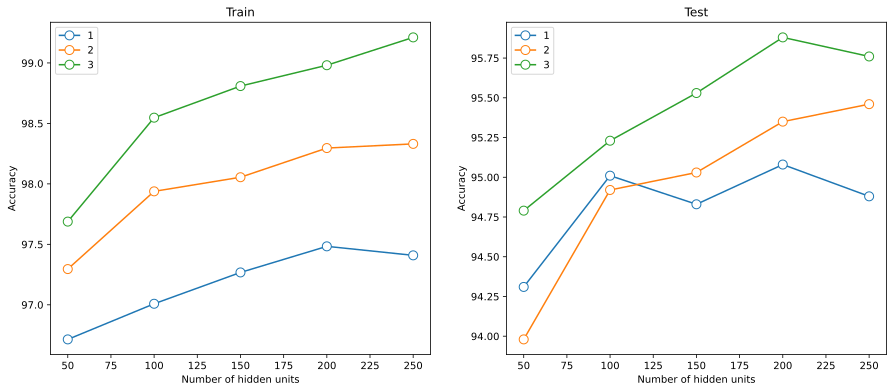

In [ ]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()